# Uncertainty analysis of a 2-D slice model

Possible paper titles: 

Posterior analysis of geological models/ geophysical inversions? with information theory

...with measures from information theory

...with information theoretic measures

...with information measures

...with information

Ensemble analysis...

Posterior and ensemble analysis...

(Note: reference to posterior analysis, e.g. in Tarantola paper!)

Include:

- Analysis of pynoddy models:
    - simple example of graben (because the uncertainty reduction is so counter-intuitive), 
    - and maybe more complex example of folding structure?
- Analysis of object modelling results? (i.e. the typical "Stanford channels"? but: only two outcomes, so not so meaningful... better example?)
- Analysis of posterior ensemble from geophysical inversion (Greenstone model? Other examples from Mark & Mark?)

Journal? Math. Geo? Tectonophysics (note: relevance to strucural geological models!)

Include theory: error bounds on information measures!






In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [2]:
%matplotlib inline

In [7]:
# here the usual imports. If any of the imports fails, 
# make sure that pynoddy is installed
# properly, ideally with 'python setup.py develop' 
# or 'python setup.py install'
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
sys.path.append('../..')
import pynoddy
import importlib
importlib.reload(pynoddy)
import pynoddy.history
import pynoddy.experiment
importlib.reload(pynoddy.experiment)
rcParams.update({'font.size': 15})


In [ ]:
pynoddy.history.NoddyHistory(history="typeb.his")

## Model set-up

Subsequently, we will use a model from the "Atlas of Structural Geophysics" as an example model.

In [ ]:
from pynoddy.experiment import monte_carlo
model_url = 'http://tectonique.net/asg/ch3/ch3_7/his/typeb.his'
ue = pynoddy.experiment.Experiment(history="typeb.his")

In [ ]:
ue.change_cube_size(100)
sec = ue.get_section('y')

In [ ]:
tmp = open("typeb.his").readlines()

In [ ]:
tmp[0], response[0]

## BUG!!!!

Note: there is either a bug in pynoddy or in Noddy itself: but the slice plotting method fails: actually, not a slice is computed but the entire model (and the extent is also not correct!). Check with Mark in course of paper prep!

In [ ]:
sec.block.shape

In [ ]:
ue.plot_section('y')

In [ ]:
plt.imshow(sec.block[:,50,:].transpose(), origin = 'lower left', interpolation = 'none')

In [ ]:
tmp = sec.block[:,50,:]
tmp.shape

In [ ]:
ue.set_random_seed(12345)

In [ ]:
ue.info(events_only = True)

We now define the parameter uncertainties:

In [ ]:
param_stats = [{'event' : 2, 
              'parameter': 'Amplitude',
              'stdev': 100.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'Wavelength',
              'stdev': 500.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 500.0,
              'type': 'normal'}]

ue.set_parameter_statistics(param_stats)

And, in a next step, perform the model sampling:

In [ ]:
ue.set_random_seed(112358)
# perfrom random sampling
resolution = 100
sec = ue.get_section('y')

tmp = sec.block[:,50,:]
n_draws = 5000
model_sections = np.empty((n_draws, tmp.shape[0], tmp.shape[1]))

for i in range(n_draws):
    ue.random_draw()
    tmp_sec = ue.get_section('y', resolution = resolution, 
                             remove_tmp_files = True)
    model_sections[i,:,:] = tmp_sec.block[:,50,:]

Save the model data for later re-use (e.g. to extend the data set):

In [4]:
import pickle

In [ ]:
f_out = open("model_sections_5k2.pkl", 'wb')

In [ ]:
pickle.dump(model_sections, f_out)

In [5]:
f_in = open("model_sections_5k2.pkl", 'rb')
model_sections = pickle.load(f_in)

## Use hspace to calculate joint entropies

Adjusted notebook: use `hspace`-package to calculate information theoretic measures

In [10]:
sys.path.append('/Users/flow/git/hspace')

In [11]:
import hspace.measures
importlib.reload(hspace.measures)

<module 'hspace.measures' from '/Users/flow/git/hspace/hspace/measures.py'>

In [12]:
model_sections.shape


(5000, 100, 40)

## Calculation of cell information entropy

(Include note on: theory of entropy calculation)

(Include in this paper: estimates on error bounds?)

Here now the function to calculate entropy from a data array in general. What we will need to do later is to pass all results at a single position as a "data array" and we can then estimate the information entropy at this position.

This function already expects a sorted array as an input and then uses the (ultra-fast) switchpoint method to calculate entropy:

The algorithm works on the simple idea that we do not explicitly require the single outputs at each location, but only the relative probability values. This may not matter too much for single entropy estimates (uni-variate), but it will matter a lot for multivariate cases, because we do not need to check all possible outcomes! Note that all outcomes with zero probability are simply not considered in the sorting algorithm (and they do not play any role in the calculation of the entropy, anyway), and that's exactly what we want to have!

In this new version, we use the implementation the `hspace` package:

In [13]:
hspace.measures.joint_entropy(model_sections[:,50,:], [0,1])

12.097379144534736

In [14]:
h = np.empty_like(model_sections[0,:,:])
for i in range(100):
    for j in range(40):
        h[i,j] = hspace.measures.joint_entropy(model_sections[:,i,j])
h[50,30]

1.5373957598393617

We now visualise the cell information entropy, shown in Fig. (). We can here clearly identify uncertain regions within this model section. It is interesting to note that we can mostly still identify the distinct layer boundaries in the fuzzy areas of uncertainty around their borders (note: highlight in Figure!). However, additional aspects of uncertainty are now introduced: (a) the uncertainty about the x-position of the folds (see parameters: event 2, parameter x) is now clearly visible, and (b) uncertianties now seem to concentrate on the fold hinges. However, this is not so clear in the left part of the model, where the fold hing seems to be the least uncertain part. (check why: is this where the fold is actually fixed (even though still uncertain). My current interpretation: the fold location is fixed somewhere near this point, and so the wavelength uncertainty does not play a significant role. Furthermore, the fold is quite "open" at this position (i.e.: low angle between hinges) and therefore lateral shifts do not play a significant role.

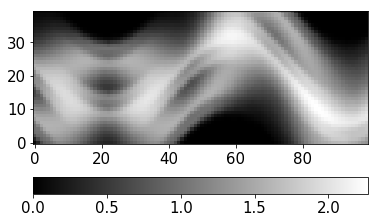

In [15]:
plt.imshow(h.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')

Here again an example of single models (adjust to visualise and probably include something like a "table plot" of multiple images for a paper!):

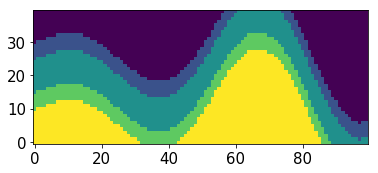

In [16]:
plt.imshow(model_sections[70,:,:].transpose(), origin = 'lower left', interpolation = 'none')

And here the "mean" lithologies (note: not really a distinct meaning, simply showing the average litho ids - could be somehow interpreted as characteristic functions, though...).

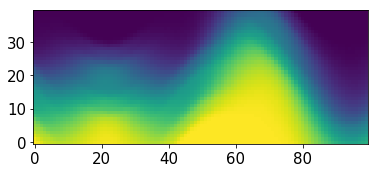

In [17]:
plt.imshow(np.mean(model_sections, axis = 0).transpose(), origin = 'lower left', interpolation = 'none')

And here a bit more meaningful: the analysis of single layer probabilities:

In [19]:
# step 1: estimate probabilities (note: unfortunate workaround with ones multiplication,
# there may be a better way, but this is somehow a recurring problem of implicit
# array flattening in numpy)
litho_id = 4
prob = np.sum(np.ones_like(model_sections) * (model_sections == litho_id), axis = 0) / model_sections.shape[0]

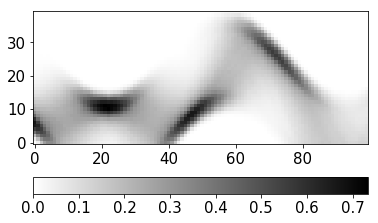

In [20]:
plt.imshow(prob.transpose(), 
           origin = 'lower left', 
           interpolation = 'none', 
           cmap = 'gray_r')
plt.colorbar(orientation = 'horizontal')

Idea: also include a "new" consideration: where to collect information to reduce uncertainty of a single layer? Could be identified by reducing layer fuzziness, for example!

Or: what are most likely positions/ locations of a specific unit, given collected information?




<div class="alert alert-warning">
<b>More ideas:</b> 
<ul>
<li>General methods to create simple representations in 1-D, 2-D?
<li>Automatic probability plots (note: simple in 1-D, but also for slices in 2-D?) => Compare visualisations in previous notebooks!
</ul>
</div>

## Analysis of multivariate condtional entropy

Later also:

- "opposite" question, i.e.: if we would like to resolve uncertainty in a specific region: where to look best?
- "complete" uncertainty (i.e.: joint entropy!)
- greedy search for best spots for uncertainty reduction, simple (cell-wise), complex (related to potential drilling positions)
- further ideas for "greedy search" to reduce uncertainties in a specific "search region" (i.e.: expected location of a deposit, etc.):
    - start with cell with highest (multivariate) mutual information
    - rank cells with highest I due to their own mutual information with other cells, which are not part of a defined "search region"
- for simple, cell-wise: describe similarity to mapping! Maybe even a field example with data from Belgium? But this is still one or two MSc theses away...)

For the joint entropy analysis, we now use the new lexicographic (correct term?) sorting algorithm, implemented in the module hspace:

In [21]:
importlib.reload(hspace.measures)

<module 'hspace.measures' from '/Users/flow/git/hspace/hspace/measures.py'>

In [22]:
dx = 15
xvals = np.ones(dx, dtype=int) * 20
yvals = np.arange(11,11+dx, dtype=int)
pos = np.vstack([xvals, yvals])


hspace.measures.joint_entropy(model_sections, pos.T)

3.4413020509431207

In [23]:
# now: define position of "drill":
nx = 10
xvals = np.ones(nx, dtype=int) * 60
yvals = np.arange(39,39-nx, -1, dtype=int)
pos = np.vstack([xvals, yvals]).T

In [24]:
# determine joint entropy of drill_locs:
h_joint_drill = hspace.measures.joint_entropy(model_sections, pos)

In [25]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add new position to positions vector:
        pos_all = np.vstack([pos, np.array([i,j])])
        # determine joint entropy
        h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 40)

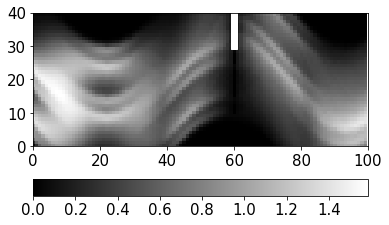

In [27]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

Try own "entropy colormap":

(0, 39)

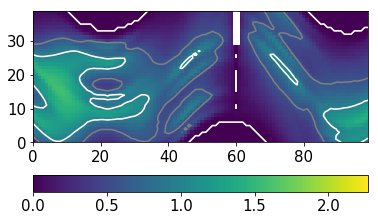

In [36]:
h_max = np.max(h)
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'viridis', interpolation = 'none', vmax=h_max)
plt.colorbar(orientation = 'horizontal')
# half-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, .5))
plt.contour(h_cond_drill.transpose(), contour_levels, colors = 'gray')
# superpose 1-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, 1.))
plt.contour(h_cond_drill.transpose(), contour_levels, colors = 'white')

plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

For comparison again: the entropy of the initial model:

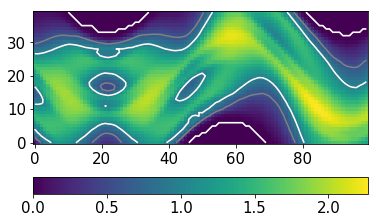

In [39]:
plt.imshow(h.transpose(), origin = 'lower left',
          cmap = 'viridis', interpolation = 'none', vmax=h_max)
plt.colorbar(orientation = 'horizontal')
# half-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, .5))
plt.contour(h.transpose(), contour_levels, colors = 'gray')
# superpose 1-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, 1.))
plt.contour(h.transpose(), contour_levels, colors = 'white')


And the difference, for clarity:

(0, 39)

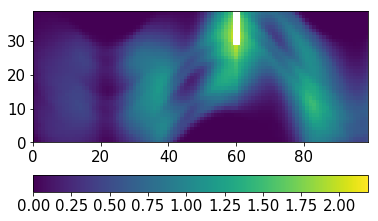

In [40]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'viridis', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:


plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

Clearly, the highset reduction is in the area around the borehole, but interestingly, the uncertianty in other areas is also reduced! Note specifically the reduction of uncertainties in the two neighbouring fold hinges.

Let's check some other positions (and drilling "depths"):

In [41]:
# define position of "drill":
nx = 10
xvals = np.ones(nx, dtype=int) * 20
yvals = np.arange(39,39-nx, -1, dtype=int)
pos = np.vstack([xvals, yvals]).T

# determine joint entropy of drill_locs:
h_joint_drill = hspace.measures.joint_entropy(model_sections, pos)

We also just include one timing step to estimate the approximate simualtion time:

In [44]:
%%timeit
pos_all = np.vstack([pos, np.array([50,20])])
h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)

100 loops, best of 3: 2.71 ms per loop


In [46]:
# esimated total time:
ttime = 100 * 40 * 0.000271
print("Estimated total time: %.3f seconds or %.3f minutes" % (ttime, ttime/60.))

Estimated total time: 1.084 seconds or 0.018 minutes


In [47]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        pos_all = np.vstack([pos, np.array([i,j])])
        h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 39)

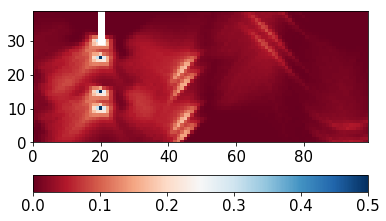

In [49]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

Intersting! Only a local reduction around the drilling position, however: extending to the deeper layers, as well! Why?

Drill deeper:

In [50]:
# define position of "drill":
nx = 30
xvals = np.ones(nx, dtype=int) * 20
yvals = np.arange(39,39-nx, -1, dtype=int)
pos = np.vstack([xvals, yvals]).T

# determine joint entropy of drill_locs:
h_joint_drill = hspace.measures.joint_entropy(model_sections, pos)

In [51]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        pos_all = np.vstack([pos, np.array([i,j])])
        h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 39)

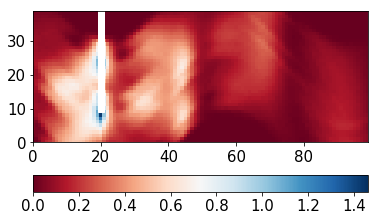

In [52]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

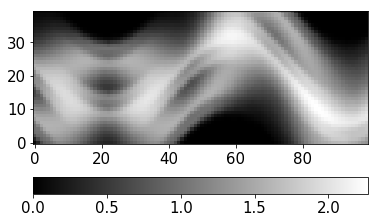

In [53]:
plt.imshow(h.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')

(0, 39)

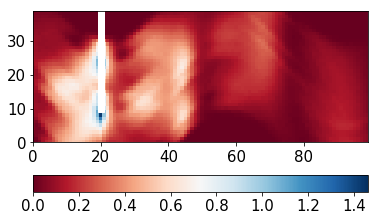

In [55]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

### Check deep "drilling" at pos 60

In [56]:
# define position of "drill":
nx = 30
xvals = np.ones(nx, dtype=int) * 60
yvals = np.arange(39,39-nx, -1, dtype=int)
pos = np.vstack([xvals, yvals]).T

# determine joint entropy of drill_locs:
h_joint_drill = hspace.measures.joint_entropy(model_sections, pos)

In [57]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        pos_all = np.vstack([pos, np.array([i,j])])
        h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 39)

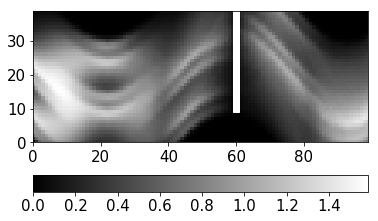

In [58]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

(0, 39)

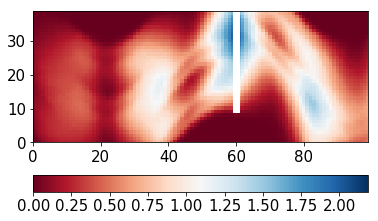

In [59]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

Interesting! And now both combined:

In [61]:
# define position of "drill":
nx = 30
xvals = np.hstack([np.ones(nx, dtype=int) * 60, np.ones(nx, dtype=int) * 30])
yvals = np.hstack([np.arange(39,39-nx, -1, dtype=int), np.arange(39,39-nx, -1, dtype=int)])
pos = np.vstack([xvals, yvals]).T

# determine joint entropy of drill_locs:
h_joint_drill = hspace.measures.joint_entropy(model_sections, pos)

In [62]:
%%timeit
h_joint_loc = hspace.measures.joint_entropy(model_sections, pos)

10 loops, best of 3: 20.1 ms per loop


In [63]:
# esimated total time:
ttime = 100 * 40 * 0.0002
print("Estimated total time: %.3f seconds or %.3f minutes" % (ttime, ttime/60.))

Estimated total time: 0.800 seconds or 0.013 minutes


In [64]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        pos_all = np.vstack([pos, np.array([i,j])])
        h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 39)

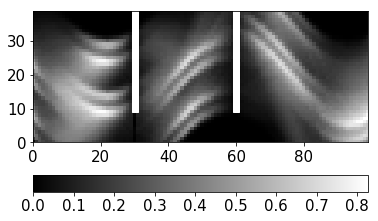

In [66]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

(0, 39)

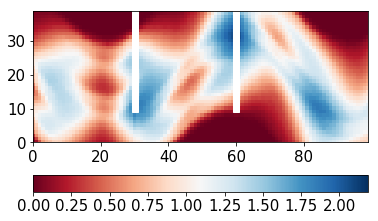

In [67]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

We can see that now only a part on the left remains with significant uncertainties. So, let's "drill" into this, as well:

In [68]:
# define position of "drill":
nx = 30
xvals = np.hstack([np.ones(nx, dtype=int) * 60, 
                   np.ones(nx, dtype=int) * 30,
                   np.ones(nx, dtype=int) * 5])
yvals = np.hstack([np.arange(39,39-nx, -1, dtype=int), 
                   np.arange(39,39-nx, -1, dtype=int), 
                   np.arange(39,39-nx, -1, dtype=int)])
pos = np.vstack([xvals, yvals]).T

# determine joint entropy of drill_locs:
h_joint_drill = hspace.measures.joint_entropy(model_sections, pos)


In [69]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        pos_all = np.vstack([pos, np.array([i,j])])
        h_joint_loc = hspace.measures.joint_entropy(model_sections, pos_all)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 39)

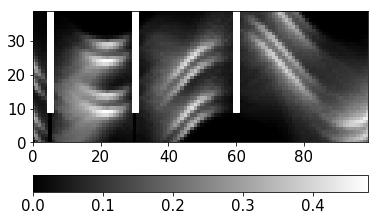

In [70]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

(0, 39)

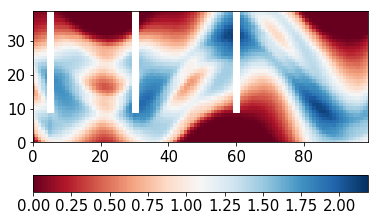

In [71]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
plt.plot(pos[:,0], pos[:,1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

Additional idea to speed up computation (especially for higher multivariate examples): do not estimate value at locations where conditional entropy of subset (i.e.: often previously calculated)! (Check: theoretical reason/ justification!)